In [1]:
import pandas as pd


In [2]:
# Replace 'anomaly_detected_logins_large.csv' with your file path if needed
df = pd.read_csv('anomaly_detected_logins_large.csv')


In [3]:
print(df.head())


   user_id           login_time       ip_address        location  \
0        1  2025-01-08 21:27:25   175.128.193.19   Port Saratown   
1        2  2025-01-03 19:13:16  162.239.146.227  South Julieton   
2        3  2025-03-06 13:32:46    79.245.54.205        Johnbury   
3        4  2025-03-04 15:01:44    113.248.35.30   Mitchellmouth   
4        5  2025-01-03 19:55:53   37.141.146.181       Sarashire   

   anomaly_score  
0          0.392  
1          0.509  
2          0.780  
3          0.253  
4          0.135  


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        100000 non-null  int64  
 1   login_time     100000 non-null  object 
 2   ip_address     100000 non-null  object 
 3   location       100000 non-null  object 
 4   anomaly_score  100000 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.8+ MB
None


In [6]:
print(df.isnull().sum())


user_id          0
login_time       0
ip_address       0
location         0
anomaly_score    0
dtype: int64


In [7]:
import pandas as pd

# Load the dataset (replace path if needed)
df = pd.read_csv('anomaly_detected_logins_large.csv')

# See the first 5 rows to understand what the data looks like
print(df.head())

# Check data types and if there are missing values
print(df.info())

# Get summary statistics to see data spread (optional)
print(df.describe())


   user_id           login_time       ip_address        location  \
0        1  2025-01-08 21:27:25   175.128.193.19   Port Saratown   
1        2  2025-01-03 19:13:16  162.239.146.227  South Julieton   
2        3  2025-03-06 13:32:46    79.245.54.205        Johnbury   
3        4  2025-03-04 15:01:44    113.248.35.30   Mitchellmouth   
4        5  2025-01-03 19:55:53   37.141.146.181       Sarashire   

   anomaly_score  
0          0.392  
1          0.509  
2          0.780  
3          0.253  
4          0.135  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        100000 non-null  int64  
 1   login_time     100000 non-null  object 
 2   ip_address     100000 non-null  object 
 3   location       100000 non-null  object 
 4   anomaly_score  100000 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage:

In [10]:
# Convert the 'timestamp' column to datetime type
df['login_time'] = pd.to_datetime(df['login_time'])

# Extract new features: hour of day, day of month, weekday (0=Monday)
df['hour'] = df['login_time'].dt.hour
df['day'] = df['login_time'].dt.day
df['weekday'] = df['login_time'].dt.weekday

# Check if there are any missing values in these columns
print(df[['login_time', 'hour', 'day', 'weekday']].isnull().sum())

# Fill or drop missing values if necessary (example: forward fill)
df.fillna(method='ffill', inplace=True)


login_time    0
hour          0
day           0
weekday       0
dtype: int64


<ipython-input-10-364bbd6b2809>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [9]:
print(df.columns)



Index(['user_id', 'login_time', 'ip_address', 'location', 'anomaly_score'], dtype='object')


In [11]:
# Group data by User_ID and day to aggregate daily behavior
features_df = df.groupby(['user_id', 'day']).agg({
    'login_time': 'count',      # Number of logins in that day (activity count)
    'hour': ['mean', 'std'],   # Average login hour and variability
}).reset_index()

# Flatten multi-level column names after aggregation
features_df.columns = ['user_id', 'day', 'login_count', 'avg_login_hour', 'std_login_hour']

# Handle NaNs that may appear if only one login (std = NaN)
features_df['std_login_hour'] = features_df['std_login_hour'].fillna(0)

print(features_df.head())


   user_id  day  login_count  avg_login_hour  std_login_hour
0        1    8            1            21.0             0.0
1        2    3            1            19.0             0.0
2        3    6            1            13.0             0.0
3        4    4            1            15.0             0.0
4        5    3            1            19.0             0.0


In [12]:
from sklearn.preprocessing import StandardScaler

# Features to use for anomaly detection
feature_cols = ['login_count', 'avg_login_hour', 'std_login_hour']

# Extract feature matrix
X = features_df[feature_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
from sklearn.ensemble import IsolationForest

# Initialize model with estimated contamination (expected anomaly fraction)
model = IsolationForest(contamination=0.05, random_state=42)

# Fit model
model.fit(X_scaled)

# Predict anomalies (-1 means anomaly, 1 means normal)
features_df['anomaly'] = model.predict(X_scaled)

# Map predictions to 0 (normal) and 1 (anomaly)
features_df['anomaly'] = features_df['anomaly'].map({1: 0, -1: 1})

print(features_df.head())


   user_id  day  login_count  avg_login_hour  std_login_hour  anomaly
0        1    8            1            21.0             0.0        0
1        2    3            1            19.0             0.0        0
2        3    6            1            13.0             0.0        0
3        4    4            1            15.0             0.0        0
4        5    3            1            19.0             0.0        0


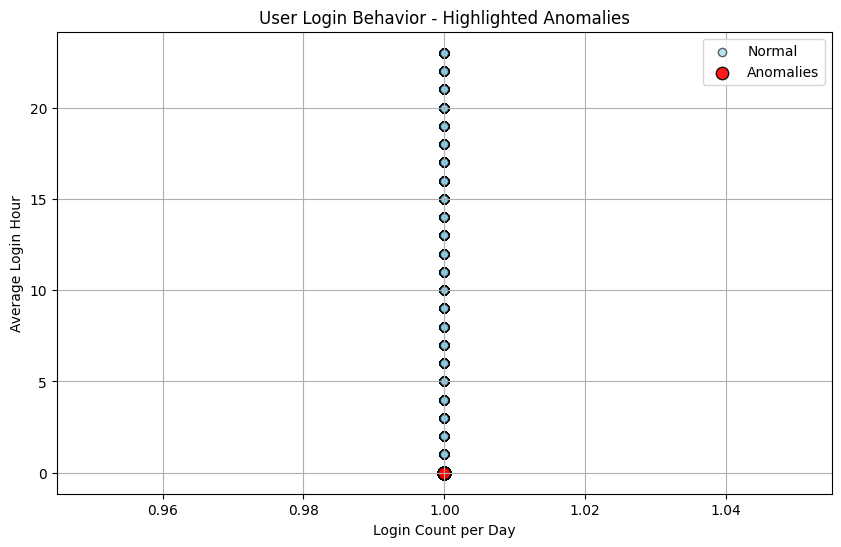

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Separate anomalies and normal points for better contrast
normal = features_df[features_df['anomaly'] == 0]
anomalies = features_df[features_df['anomaly'] == 1]

# Plot normal points
plt.scatter(
    normal['login_count'],
    normal['avg_login_hour'],
    color='skyblue',
    label='Normal',
    alpha=0.6,
    edgecolors='k'
)

# Plot anomaly points
plt.scatter(
    anomalies['login_count'],
    anomalies['avg_login_hour'],
    color='red',
    label='Anomalies',
    alpha=0.9,
    s=80,
    edgecolors='black'
)

plt.xlabel('Login Count per Day')
plt.ylabel('Average Login Hour')
plt.title('User Login Behavior - Highlighted Anomalies')
plt.legend()
plt.grid(True)
plt.show()

